# Census Bureau Segmentation for Retail Marketing (Unsupervised Learning)

This notebook builds a **customer segmentation model** (unsupervised clustering) on the Census Bureau dataset for retail marketing use cases.

**Goal:** Group people into segments with distinct demographic / economic profiles that a retail client can target differently.

> Note: The `label` (income class) is **not used** during clustering. We only use it later to **describe** segments.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:


csv_path = r"./census-bureau.csv"

# The file is large; so we will use sampling to keep the workflow responsive

SAMPLE_N = 50000


df = pd.read_csv(csv_path, na_values='?')

print("Raw shape:", df.shape)
df.head()


Raw shape: (199523, 42)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,label
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [4]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(2)

missing_summary = pd.DataFrame({"missing": missing_counts, "percent_%": missing_pct})
missing_summary = missing_summary[missing_summary["missing"] > 0]

print("Columns with missing values:")
display(missing_summary)

total_missing = int(df.isna().sum().sum())
total_pct = total_missing / (df.shape[0] * df.shape[1]) * 100
print(f"Total missing cells: {total_missing:,}  ({total_pct:.2f}% of all cells)")

Columns with missing values:


,missing,percent_%
migration code-change in msa,99696,49.97
migration code-change in reg,99696,49.97
migration code-move within reg,99696,49.97
migration prev res in sunbelt,99696,49.97
country of birth father,6713,3.36
country of birth mother,6119,3.07
country of birth self,3393,1.70
hispanic origin,874,0.44
state of previous residence,708,0.35


Total missing cells: 416,591  (4.97% of all cells)


income_binary
0    187141
1     12382
Name: count, dtype: int64


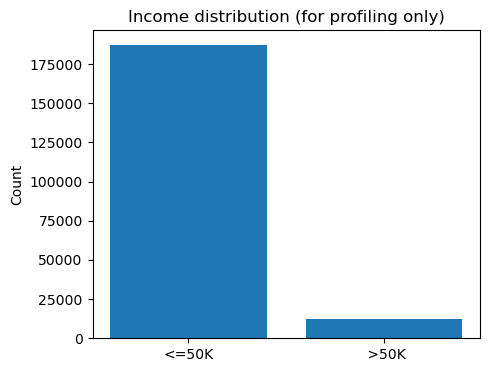

In [5]:
label_col = "label"
assert label_col in df.columns, f"Expected label column '{label_col}' not found."

def to_binary_income(x: str) -> int:
    # Common patterns in this dataset include '- 50000.' and '50000+.'
    x = str(x).strip()
    return 1 if ("50000+" in x or ">50K" in x or "> 50K" in x) else 0

df["income_binary"] = df[label_col].apply(to_binary_income)

print(df["income_binary"].value_counts(dropna=False))

plt.figure(figsize=(5,4))
counts = df["income_binary"].value_counts().sort_index()
plt.bar(["<=50K"," >50K"], counts.values)
plt.title("Income distribution (for profiling only)")
plt.ylabel("Count")
plt.show()

It looks like most of the available data is biased towards lower income 

## 3) Data Cleaning

For segmentation, we want stable, interpretable clusters. We will:
- **Drop columns with large chunks of data missing** (default: > 40% missing)
- **Drop** `weight` from features (survey sampling weight is not a person attribute)
- **Exclude** `label` and `income_binary` from clustering features (avoid leakage)
- Optionally sample rows for speed


In [8]:

MISSING_THRESHOLD_PCT = 40.0

col_missing_pct = (df.isna().sum() / len(df) * 100)
high_missing_cols = col_missing_pct[col_missing_pct > MISSING_THRESHOLD_PCT].index.tolist()

print("Dropping high-missing columns (>40%):")
for c in high_missing_cols:
    print(f" - {c}: {col_missing_pct[c]:.2f}% missing")

df_clean = df.drop(columns=high_missing_cols)

# Separate segmentation features (X) and keep label only for later profiling
drop_cols = ["label", "income_binary","weight"]

X = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns])
y_income = df_clean["income_binary"] if "income_binary" in df_clean.columns else None
print("After dropping ", df_clean.shape)
print("X shape:", X.shape)
X.head()



Dropping high-missing columns (>40%):
 - migration code-change in msa: 49.97% missing
 - migration code-change in reg: 49.97% missing
 - migration code-move within reg: 49.97% missing
 - migration prev res in sunbelt: 49.97% missing
After dropping  (199523, 39)
After dropping  (199523, 39)
X shape: (199523, 36)


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94


In [10]:
# Identify numeric vs categorical columns
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric columns:", len(numeric_cols))
print("Categorical columns:", len(categorical_cols))

# Preprocessing:
# - numeric: impute median + scale
# - categorical: impute most frequent + one-hot encode
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

X_proc = preprocessor.fit_transform(X)
print("Preprocessed shape:", X_proc.shape, " (sparse:", hasattr(X_proc, "tocsr"), ")")


Numeric columns: 12
Categorical columns: 24
Preprocessed shape: (199523, 375)  (sparse: True )


## 5) Choose optimal K 
since the data is sparce for the most part we can use SVD (Singular Value Decomposition) for speed

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:  3.2min remaining: 11.1min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  3.2min remaining:  6.4min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  3.2min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  3.2min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  3.2min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  3.2min remaining:   55.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.3min finished


,k,silhouette,calinski_harabasz,davies_bouldin
0,2,0.230363,54490.552923,1.770961
1,3,0.222762,33976.492025,2.167353
2,4,0.184398,32022.909943,2.964212
3,5,0.230669,31012.991848,1.814155
4,6,0.146587,24221.117634,2.527932
5,7,0.152246,20754.756903,2.874187
6,8,0.199347,23130.111530,2.268771
7,9,0.158979,19666.105858,2.233813
8,10,0.182306,18364.147804,2.432458


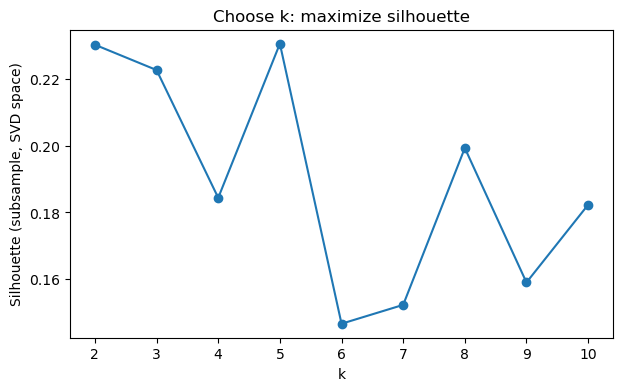

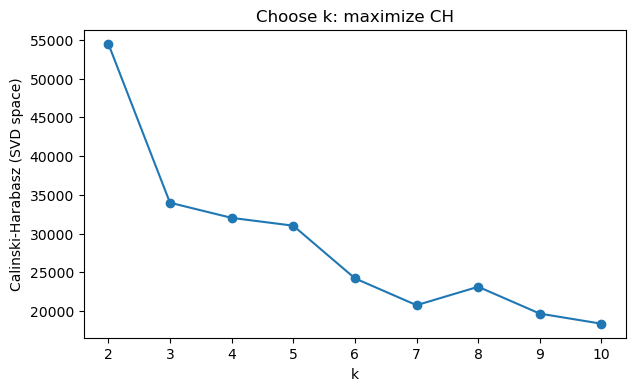

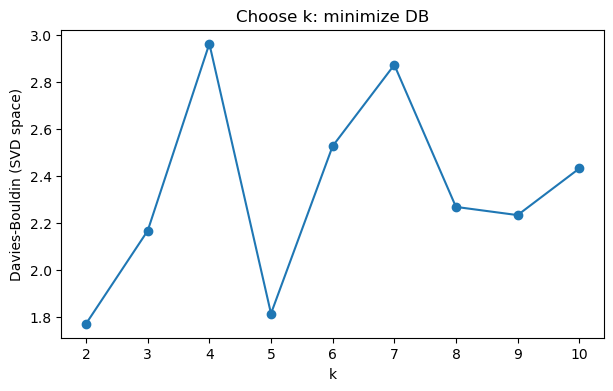

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

RANDOM_STATE = 42
K_RANGE = list(range(2, 11))

# ---------- Speed settings ----------
SIL_SAMPLE = 100000     # silhouette computed on a subset since it was computationally expensive to do on entire dataset (set to None if you dont need it)
SVD_DIM = 150           
BATCH_SIZE = 4096
N_INIT = 3
N_JOBS = -1            # use all CPUs

svd = TruncatedSVD(n_components=SVD_DIM, random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X_proc)  

n = X_svd.shape[0]
rng = np.random.default_rng(RANDOM_STATE)
sil_idx = rng.choice(n, size=min(SIL_SAMPLE, n), replace=False)

def fit_score_k(k: int):
    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=RANDOM_STATE,
        batch_size=BATCH_SIZE,
        n_init=N_INIT
    )

    labels = km.fit_predict(X_proc.copy())  

    sil = silhouette_score(X_svd[sil_idx], labels[sil_idx])
    ch = calinski_harabasz_score(X_svd, labels)
    db = davies_bouldin_score(X_svd, labels)

    return {"k": k, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db}

rows = Parallel(n_jobs=N_JOBS, verbose=10)(
    delayed(fit_score_k)(k) for k in K_RANGE
)

scores = pd.DataFrame(rows).sort_values("k")
display(scores)

plt.figure(figsize=(7,4))
plt.plot(scores["k"], scores["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (subsample, SVD space)")
plt.title("Choose k: maximize silhouette")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(scores["k"], scores["calinski_harabasz"], marker="o")
plt.xlabel("k")
plt.ylabel("Calinski-Harabasz (SVD space)")
plt.title("Choose k: maximize CH")
plt.show()

plt.figure(figsize=(7,4))
plt.plot(scores["k"], scores["davies_bouldin"], marker="o")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin (SVD space)")
plt.title("Choose k: minimize DB")
plt.show()

,k,ari_mean,ari_std
0,2,0.999770,0.000083
1,3,0.999735,0.000091
2,4,0.999724,0.000111
3,5,0.891653,0.118436
4,6,0.869711,0.096226
5,7,0.844547,0.082827
6,8,0.873505,0.093000


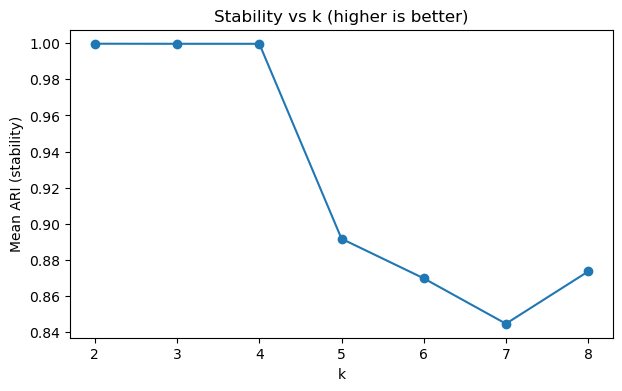

In [16]:
from itertools import combinations

def kmeans_stability_ari(X_proc, k, n_runs=8, subsample_frac=0.8, random_state=42):
    rng = np.random.default_rng(random_state)
    n = X_proc.shape[0]
    all_labels = []

    for r in range(n_runs):
        idx = rng.choice(n, size=int(subsample_frac*n), replace=False)
        km = KMeans(n_clusters=k, random_state=random_state + r, n_init=10)
        km.fit(X_proc[idx])
        full_labels = km.predict(X_proc)
        all_labels.append(full_labels)
    aris = []
    for i, j in combinations(range(n_runs), 2):
        aris.append(adjusted_rand_score(all_labels[i], all_labels[j]))

    return np.array(aris), all_labels
    
# Compare stability for several K values
stability_rows = []
for k in range(2, 9):
    aris_k, _ = kmeans_stability_ari(X_proc, k, n_runs=8, subsample_frac=0.8, random_state=RANDOM_STATE)
    stability_rows.append({"k": k, "ari_mean": aris_k.mean(), "ari_std": aris_k.std()})

stab = pd.DataFrame(stability_rows)
display(stab)

plt.figure(figsize=(7,4))
plt.plot(stab["k"], stab["ari_mean"], marker="o")
plt.xlabel("k")
plt.ylabel("Mean ARI (stability)")
plt.title("Stability vs k (higher is better)")
plt.show()


While K = 5 has best silhouette but its stability is quite low so we do a compromise of putting K = 3

In [17]:

BEST_K = 3
print(" BEST_K :", BEST_K)


 BEST_K : 3


### Fit final segmentation model

In [18]:
kmeans = KMeans(n_clusters=BEST_K, random_state=RANDOM_STATE, n_init=20)
cluster_labels = kmeans.fit_predict(X_proc)

seg = df_clean.copy()
seg["cluster"] = cluster_labels

seg["cluster"].value_counts().sort_index()


cluster
0    47495
1    99219
2    52809
Name: count, dtype: int64

## 8) Visualize clusters (2D projection)
We use SVD as well as PCA for Visualistion

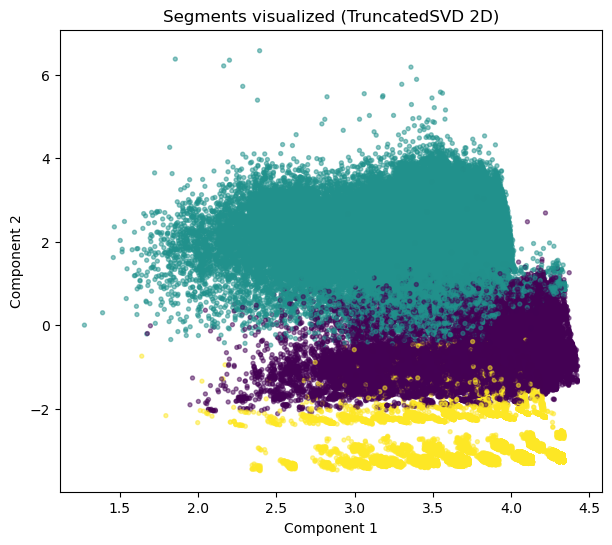

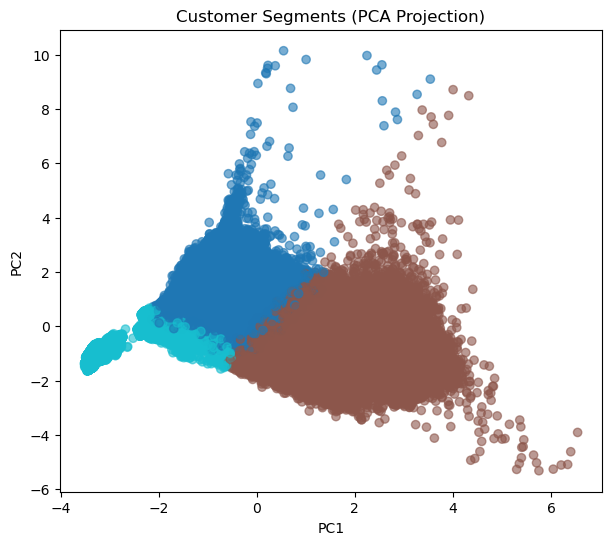

In [21]:
# Use TruncatedSVD for sparse one-hot matrices (works like PCA for sparse)
svd = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
X_2d = svd.fit_transform(X_proc)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=seg["cluster"], alpha=0.5, s=8)
plt.title("Segments visualized (TruncatedSVD 2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_proc)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=seg["cluster"], cmap="tab10", alpha=0.6)
plt.title("Customer Segments (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## 9) Segment profiling: how groups differ

In [22]:
def top_categories_by_cluster(df, col, cluster_col="cluster", top_n=5):
    out = []
    for k in sorted(df[cluster_col].unique()):
        s = df.loc[df[cluster_col]==k, col].astype(str).value_counts(dropna=False).head(top_n)
        for cat, cnt in s.items():
            out.append({"cluster": k, "feature": col, "category": cat, "count": int(cnt), "percent_%": round(cnt / (df[cluster_col]==k).sum() * 100, 2)})
    return pd.DataFrame(out)

cat_features_to_show = [
    "education",
    "marital stat",
    "sex",
    "race",
    "major occupation code",
    "major industry code",
]

for col in cat_features_to_show:
    if col in seg.columns:
        display(top_categories_by_cluster(seg, col, top_n=5))


,cluster,feature,category,count,percent_%
0,0,education,High school graduate,15963,33.61
1,0,education,Some college but no degree,7511,15.81
2,0,education,7th and 8th grade,4663,9.82
3,0,education,Bachelors degree(BA AB BS),3684,7.76
4,0,education,10th grade,2948,6.21
5,1,education,High school graduate,32409,32.66
6,1,education,Some college but no degree,20297,20.46
7,1,education,Bachelors degree(BA AB BS),16180,16.31
8,1,education,Masters degree(MA MS MEng MEd MSW MBA),5417,5.46
9,1,education,Associates degree-occup /vocational,4288,4.32


,cluster,feature,category,count,percent_%
0,0,marital stat,Married-civilian spouse present,25634,53.97
1,0,marital stat,Widowed,8554,18.01
2,0,marital stat,Never married,8244,17.36
3,0,marital stat,Divorced,3174,6.68
4,0,marital stat,Separated,1129,2.38
5,1,marital stat,Married-civilian spouse present,58588,59.05
6,1,marital stat,Never married,25432,25.63
7,1,marital stat,Divorced,9536,9.61
8,1,marital stat,Separated,2331,2.35
9,1,marital stat,Widowed,1909,1.92


,cluster,feature,category,count,percent_%
0,0,sex,Female,31279,65.86
1,0,sex,Male,16216,34.14
2,1,sex,Male,52434,52.85
3,1,sex,Female,46785,47.15
4,2,sex,Male,26889,50.92
5,2,sex,Female,25920,49.08


,cluster,feature,category,count,percent_%
0,0,race,White,40022,84.27
1,0,race,Black,4958,10.44
2,0,race,Asian or Pacific Islander,1381,2.91
3,0,race,Other,651,1.37
4,0,race,Amer Indian Aleut or Eskimo,483,1.02
5,1,race,White,85303,85.97
6,1,race,Black,8580,8.65
7,1,race,Asian or Pacific Islander,2814,2.84
8,1,race,Other,1580,1.59
9,1,race,Amer Indian Aleut or Eskimo,942,0.95


,cluster,feature,category,count,percent_%
0,0,major occupation code,Not in universe,47143,99.26
1,0,major occupation code,Executive admin and managerial,146,0.31
2,0,major occupation code,Farming forestry and fishing,70,0.15
3,0,major occupation code,Adm support including clerical,44,0.09
4,0,major occupation code,Professional specialty,31,0.07
5,1,major occupation code,Adm support including clerical,14791,14.91
6,1,major occupation code,Professional specialty,13904,14.01
7,1,major occupation code,Executive admin and managerial,12348,12.45
8,1,major occupation code,Other service,12094,12.19
9,1,major occupation code,Sales,11754,11.85


,cluster,feature,category,count,percent_%
0,0,major industry code,Not in universe or children,47143,99.26
1,0,major industry code,Construction,103,0.22
2,0,major industry code,Agriculture,95,0.20
3,0,major industry code,Manufacturing-durable goods,43,0.09
4,0,major industry code,Finance insurance and real estate,20,0.04
5,1,major industry code,Retail trade,17044,17.18
6,1,major industry code,Manufacturing-durable goods,8971,9.04
7,1,major industry code,Education,8280,8.35
8,1,major industry code,Manufacturing-nondurable goods,6875,6.93
9,1,major industry code,Finance insurance and real estate,6125,6.17


### 9.3 Income composition per cluster

,<=50K,>50K
cluster,,
0,0.981682,0.018318
1,0.883974,0.116026
2,1.000000,0.000000


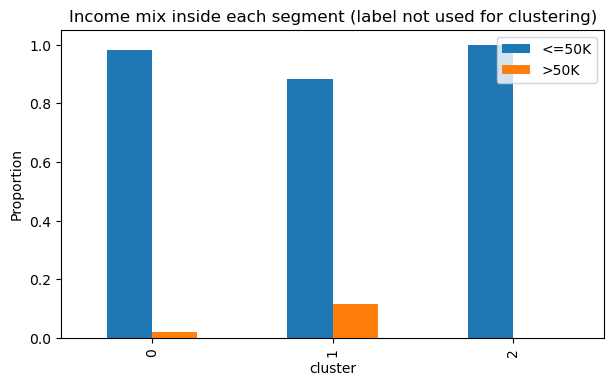

In [24]:
if "income_binary" in seg.columns:
    comp = pd.crosstab(seg["cluster"], seg["income_binary"], normalize="index")
    comp.columns = ["<=50K", ">50K"]
    display(comp)

    comp.plot(kind="bar", figsize=(7,4))
    plt.title("Income mix inside each segment (label not used for clustering)")
    plt.ylabel("Proportion")
    plt.show()


In [25]:
def safe_col(df, c):
    return c if c in df.columns else None

age_c = safe_col(seg, "age")
weeks_c = safe_col(seg, "weeks worked in year")
capg_c = safe_col(seg, "capital gains")

summary_rows = []
for k in sorted(seg["cluster"].unique()):
    g = seg[seg["cluster"]==k]
    row = {"cluster": k, "n": len(g), "pct_%": round(len(g)/len(seg)*100, 2)}

    if "income_binary" in g.columns:
        row["pct_>50K"] = round((g["income_binary"]==1).mean()*100, 2)

    if age_c: row["age_median"] = float(g[age_c].median())
    if weeks_c: row["weeks_worked_median"] = float(g[weeks_c].median())
    if capg_c: row["cap_gains_median"] = float(g[capg_c].median())

    for col in ["education", "major occupation code", "marital stat", "sex", "race"]:
        if col in g.columns:
            row[f"top_{col}"] = g[col].astype(str).value_counts().index[0]

    summary_rows.append(row)

persona_table = pd.DataFrame(summary_rows).sort_values("cluster")
display(persona_table)


,cluster,n,pct_%,pct_>50K,age_median,weeks_worked_median,cap_gains_median,top_education,top_major occupation code,top_marital stat,top_sex,top_race
0,0,47495,23.80,1.83,62.0,0.0,0.0,High school graduate,Not in universe,Married-civilian spouse present,Female,White
1,1,99219,49.73,11.60,37.0,52.0,0.0,High school graduate,Adm support including clerical,Married-civilian spouse present,Male,White
2,2,52809,26.47,0.00,8.0,0.0,0.0,Children,Not in universe,Never married,Male,White


### How a retail client can use these segments

- Cluster 0: “Kids / dependents” (26.46% of dataset, 0.00% >50K
    Profile: median age 8, 0 weeks worked
- Cluster 1: “Working married clerical households” (49.72% of dataset, 11.60% >50K)
  Profile: median age 37, 52 weeks worked (full-time year-round)
- Cluster 2: “Older married, not working (likely retired / at-home)” (23.82% of dataset, 1.83% >50K)
  Profile: median age 62, 0 weeks worked,
  
Big picture : none of the clusters are truly “high-income”; the best segment for premium upsell is Cluster 1 (highest % >50K), but it still leans value/convenience rather than luxury.